---

# University of Liverpool

## COMP534 - Applied AI

---

This notebook is associated with Assignment 1. Use it to complete the assignment by following the instructions provided in each section, which includes a text cell describing the requirements. For additional details, see the Canvas.

Use this first cell to import the necessary libraries.

In [3]:
# import libraries here
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind
import seaborn as sns
import sklearn
from sklearn import neighbors
from sklearn.decomposition import KernelPCA
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, QuantileTransformer
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier




# 1. **Data Management**


In this part, you need to:

1.   analyse and prepare the data. Use plots, graphs, and tables (such as histogram, box plots, scatterplots etc.) to better analyse the dataset and identify issues or potential improvements in the data, including (but not limited to) unnecessary feature/variable which can be dropped/removed, standardization, encoding, etc;
2.   split the data and define your experimental protocol (such as cross-validation or k-fold).

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,Grade
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,no,no,4,3,4,1,1,3,4,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,yes,no,5,3,3,1,1,3,2,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,yes,no,4,3,2,2,3,3,6,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,yes,yes,3,2,2,1,1,5,0,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,no,no,4,3,2,1,2,5,0,13


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 31 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      649 non-null    object
 1   sex         649 non-null    object
 2   age         649 non-null    int64 
 3   address     649 non-null    object
 4   famsize     649 non-null    object
 5   Pstatus     649 non-null    object
 6   Medu        649 non-null    int64 
 7   Fedu        649 non-null    int64 
 8   Mjob        649 non-null    object
 9   Fjob        649 non-null    object
 10  reason      649 non-null    object
 11  guardian    649 non-null    object
 12  traveltime  649 non-null    int64 
 13  studytime   649 non-null    int64 
 14  failures    649 non-null    int64 
 15  schoolsup   649 non-null    object
 16  famsup      649 non-null    object
 17  paid        649 non-null    object
 18  activities  649 non-null    object
 19  nursery     649 non-null    object
 20  higher    

None

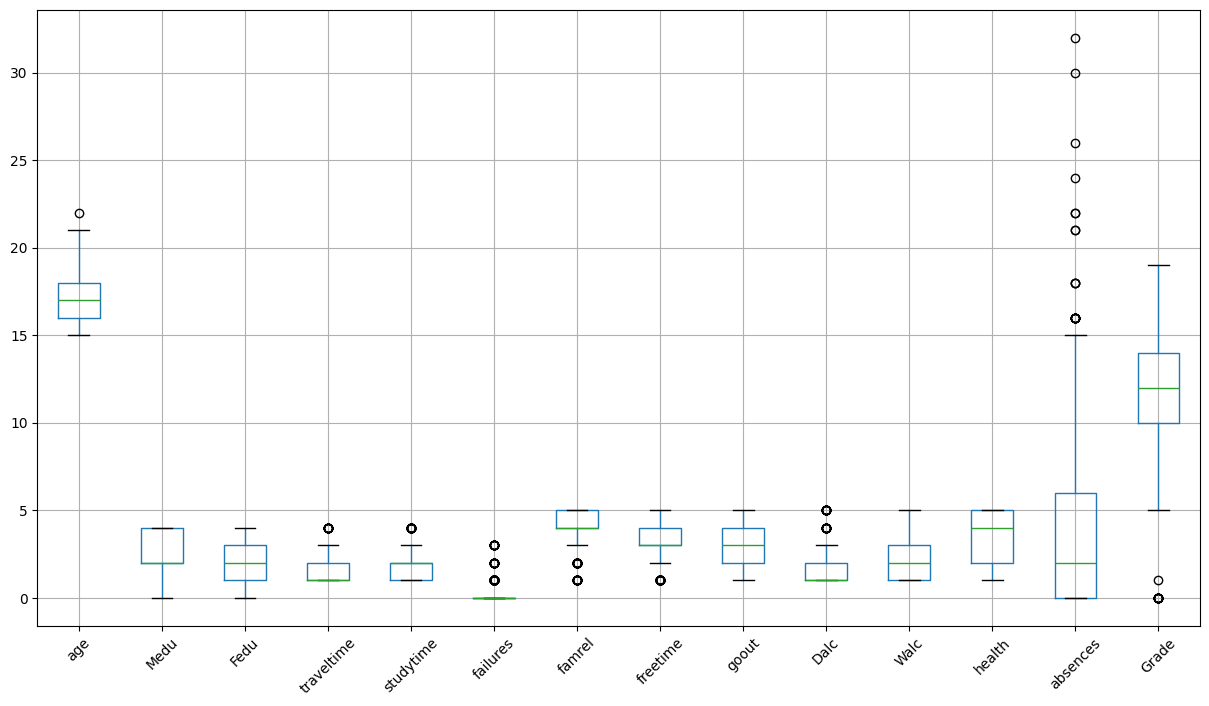

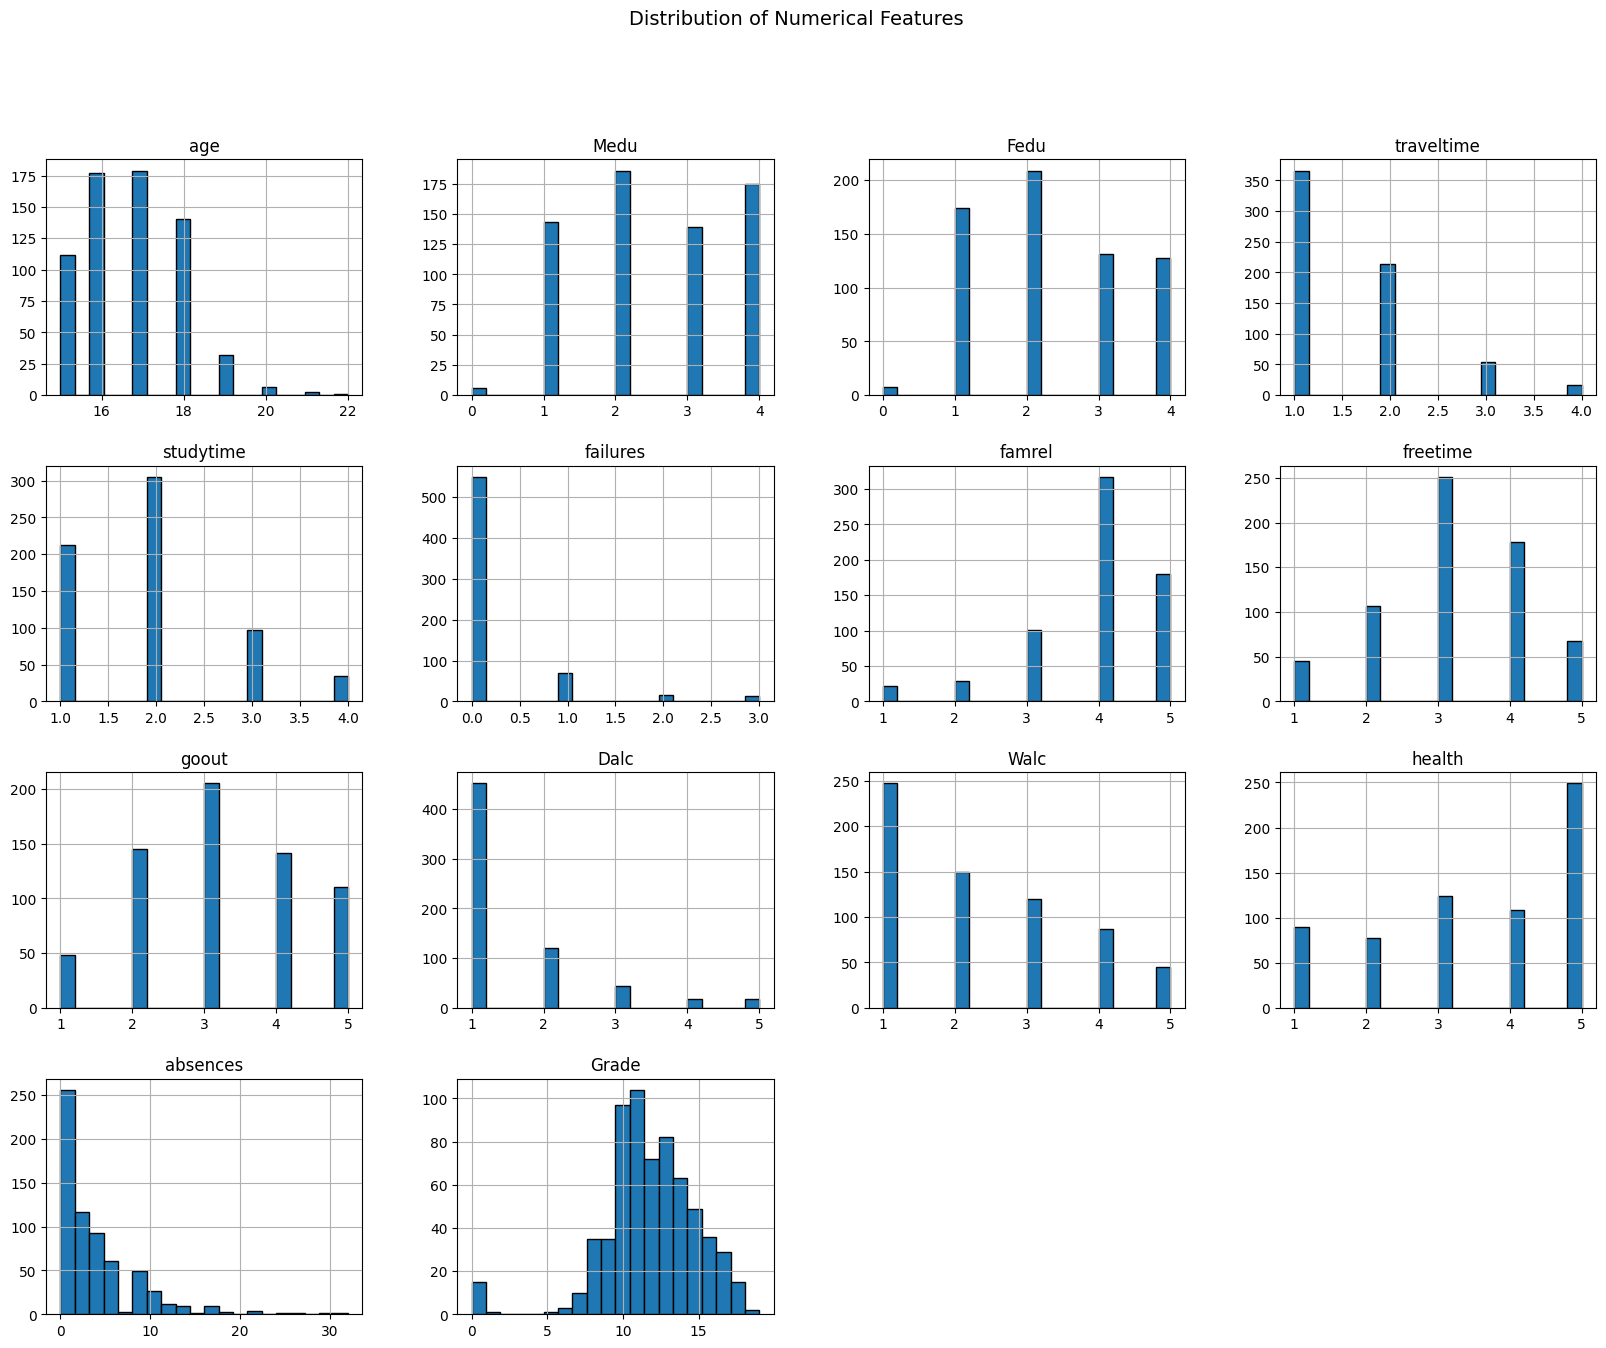

C:\Users\mohse\AppData\Local\Temp\ipykernel_40408\1627795397.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df["Pass"], palette="coolwarm")


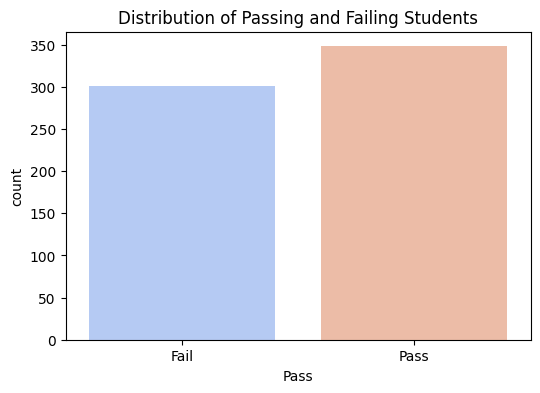

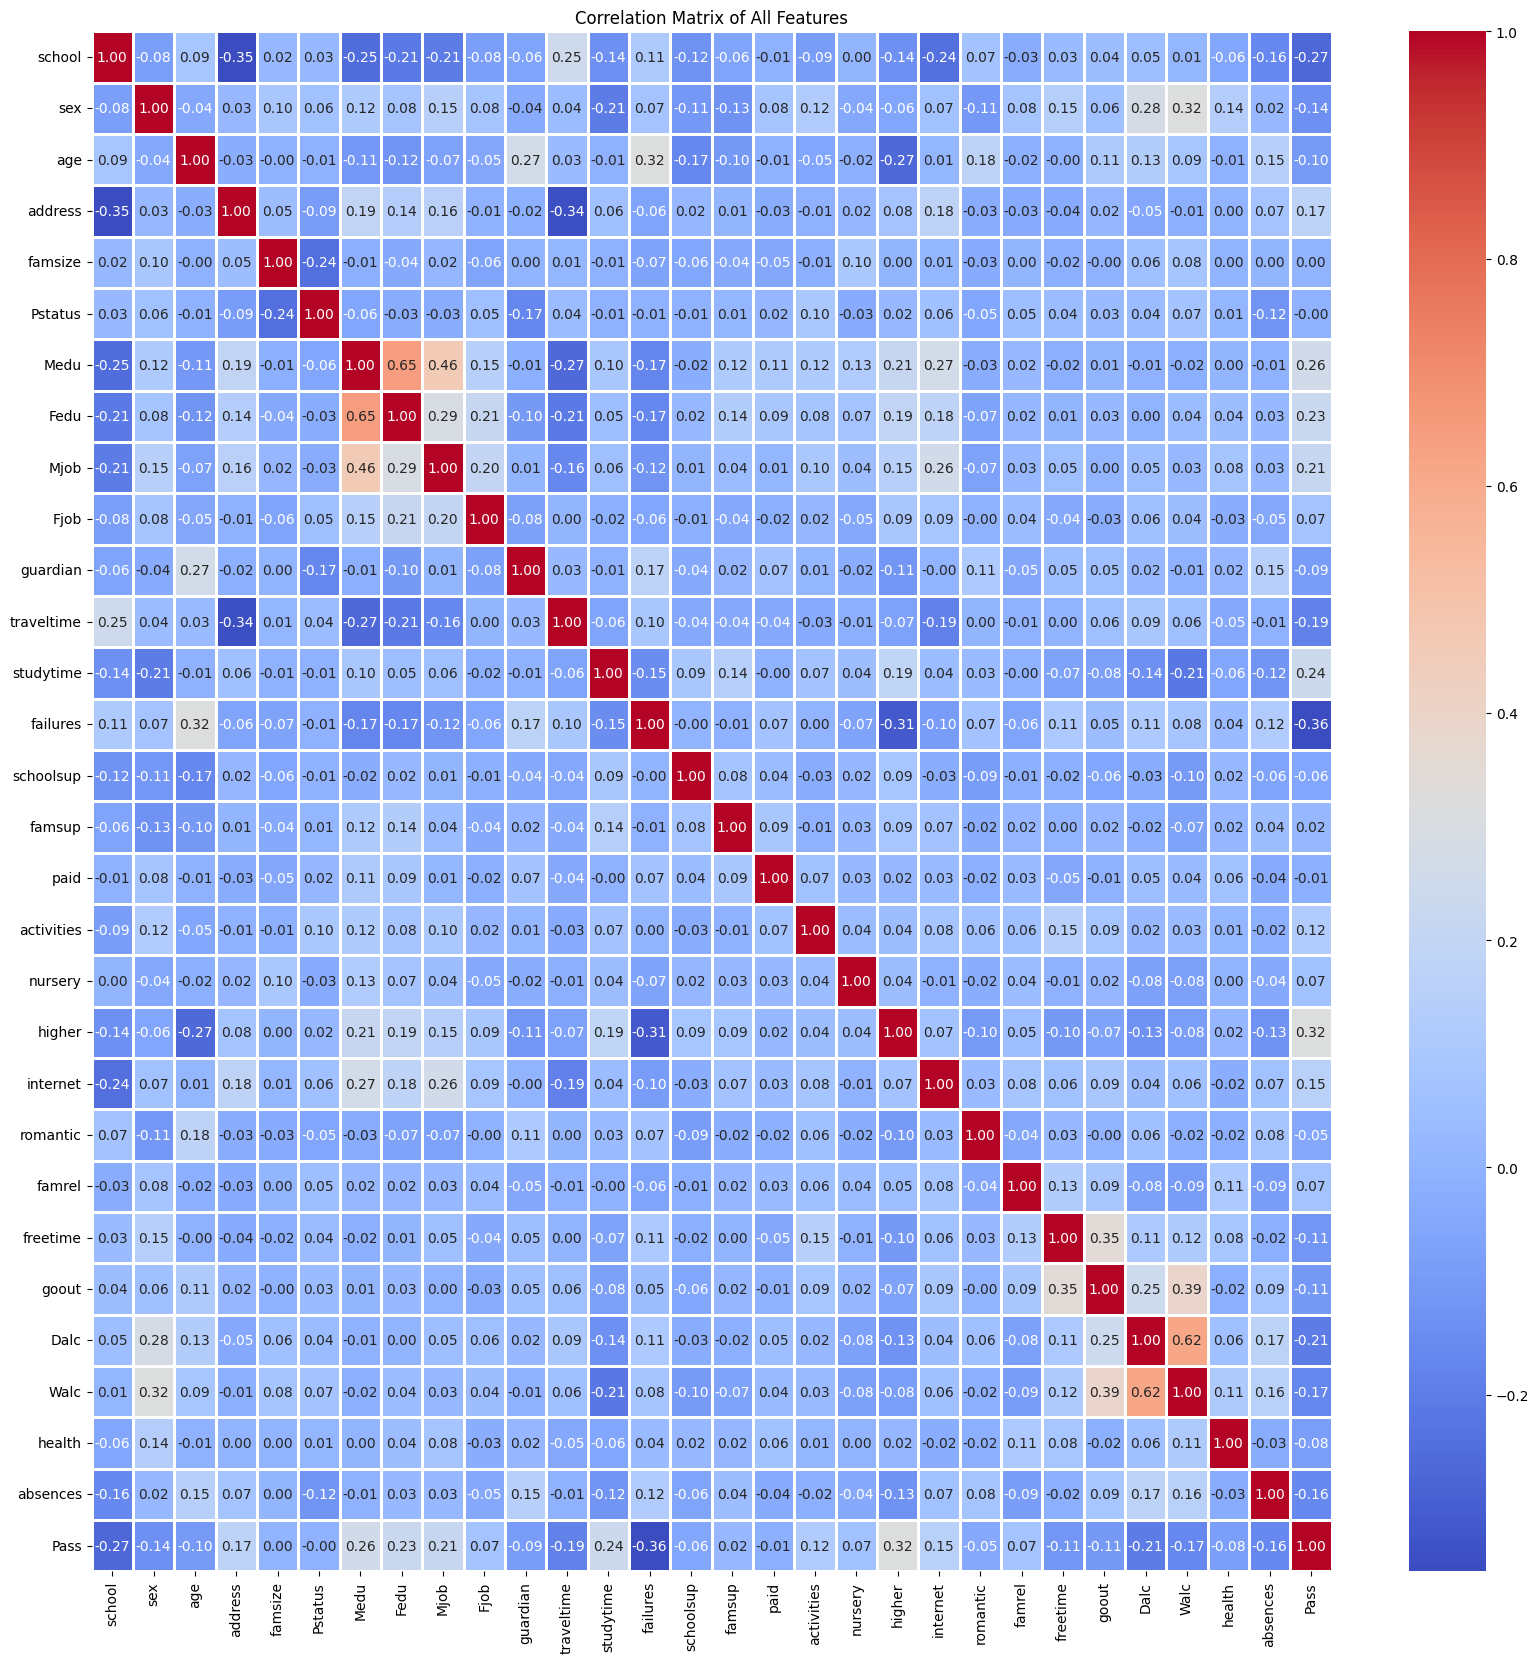

In [4]:
# Write your proposed solution code here.
# Create more code cells if you find it necessary

# Load the dataset
df = pd.read_csv("assign1-grades.csv")
display(df.head())
display(df.info())

# Display boxplots of all data
df.boxplot(figsize=(15,8), rot=45)


### Data Preparation ###
df.drop(columns="reason", inplace=True)

# Check numerical feature distributions
numeric_features = df.select_dtypes(include=["int64"]).columns.tolist()
df[numeric_features].hist(figsize=(20, 15), bins=20, edgecolor='black')
plt.suptitle("Distribution of Numerical Features", fontsize=14)
plt.show()

# Convert binary categorical dimentions ("yes"/"no") to 0/1
binary_dims = ["schoolsup", "famsup", "paid", "activities",
               "nursery", "higher", "internet", "romantic"]
df[binary_dims] = df[binary_dims].map(lambda x: 1 if x == "yes" else 0)

# Encode ordinal categorical dimentions using Label Encoding
ordinal_dims = ["school", "sex", "address", "famsize",
                "Pstatus", "Mjob", "Fjob", "guardian"]
lbe = LabelEncoder()
for col in ordinal_dims:
    df[col] = lbe.fit_transform(df[col])

# Convert Grade to a binary classification target (12+ needed for pass)
df["Pass"] = (df["Grade"] >= 12).astype(int)
df.drop(columns=["Grade"], inplace=True)

### Data Visualisation ###
# Visualize target distribution
plt.figure(figsize=(6, 4))
sns.countplot(x=df["Pass"], palette="coolwarm")
plt.xticks([0, 1], ["Fail", "Pass"])
plt.title("Distribution of Passing and Failing Students")
plt.show()

# Check correlations
plt.figure(figsize=(20, 20))
sns.heatmap(df.corr(), annot=True,
            cmap="coolwarm", fmt=".2f", linewidths=1)
plt.title("Correlation Matrix of All Features")
plt.show()

In [9]:
### Data Preparation ###

y = df["Pass"]
X = df.drop(columns=["Pass"])

X = QuantileTransformer(
    n_quantiles=649, 
    output_distribution="normal").fit_transform(X)

pca = KernelPCA(n_components=26) # 26 is BEST from repeat tests
X = pca.fit_transform(X)

# train-test split (80-20) 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    stratify=y,
                                                    random_state=42)

---

# 2. **Model Training**

Here, you need to:

1.	select and compare at least three machine learning models (seen/discussed during the lectures) appropriate for your modelling;
2.	if there are hyperparameters in a selected algorithm, define a hyperparameter search protocol (you can define your own), and tune them.


In [7]:
# Write your proposed solution code here.
# Create more code cells if you find it necessary.

def findBestParameters(model, parameters, X_train, y_train):
    """
    Perform stratified k-Fold cross validation on each model via a Grid search.
    Return a dict of the best identified parameters.

    model - the model type being cross validated.

    parameters - dict of prameters under investigation in the grid.

    X_train - training data.

    y_train - training data labels.
    """
    kFold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    gridSearch = GridSearchCV(model, parameters, cv=kFold,
                              scoring="balanced_accuracy")
    gridSearch.fit(X_train, y_train)
    print("Grid Best Params:", gridSearch.best_params_)
    return gridSearch.cv_results_, gridSearch.best_params_


def pairResults(results):
    paired_results = []
    for index, record in enumerate(results["mean_test_score"]):
        paired_results.append((record, results["params"][index]))
    return paired_results

best_models = []

In [10]:
### Random Forest ###

parameters = {
    "n_estimators": [50 ,100 ,150 ,200, 250],
    "max_features": ["sqrt", None],
}

rf_results, best_params = findBestParameters(RandomForestClassifier(), parameters, X_train, y_train)
rf = RandomForestClassifier(**best_params)

best_models.append(rf)

Grid Best Params: {'max_features': 'sqrt', 'n_estimators': 150}


(np.float64(0.7155573593073592), {'max_features': 'sqrt', 'n_estimators': 50})
(np.float64(0.7084771181199753), {'max_features': 'sqrt', 'n_estimators': 100})
(np.float64(0.7177581941867656), {'max_features': 'sqrt', 'n_estimators': 150})
(np.float64(0.715717377860235), {'max_features': 'sqrt', 'n_estimators': 200})
(np.float64(0.7137492269635126), {'max_features': 'sqrt', 'n_estimators': 250})
(np.float64(0.7105705009276437), {'max_features': None, 'n_estimators': 50})
(np.float64(0.7025247371675943), {'max_features': None, 'n_estimators': 100})
(np.float64(0.6974327458256029), {'max_features': None, 'n_estimators': 150})
(np.float64(0.6941689857761286), {'max_features': None, 'n_estimators': 200})
(np.float64(0.7069789734075449), {'max_features': None, 'n_estimators': 250})


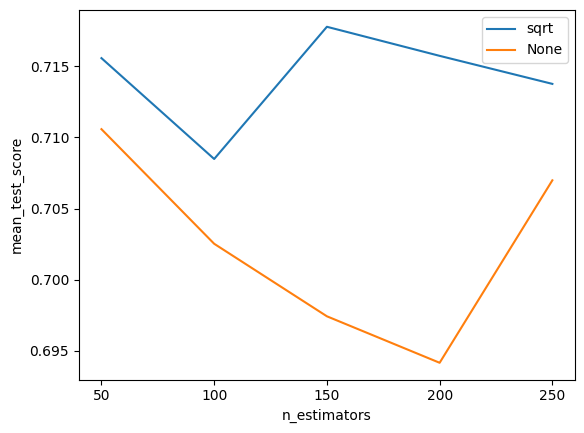

In [11]:
paired_results = pairResults(rf_results)
for record in paired_results:
    print(record)
sqrt_lim = []
none_lim = []
n_estimators = []
for record in paired_results:
    if record[1]["max_features"] == "sqrt":
        sqrt_lim.append(record[0])
        n_estimators.append(record[1]["n_estimators"])
    else:
        none_lim.append(record[0])

plt.plot(sqrt_lim, label="sqrt")
plt.plot(none_lim,  label="None")

plt.xlabel("n_estimators")
plt.xticks([0, 1, 2, 3, 4], ["50", "100", "150", "200", "250"])
plt.ylabel("mean_test_score")
plt.legend()
plt.show()

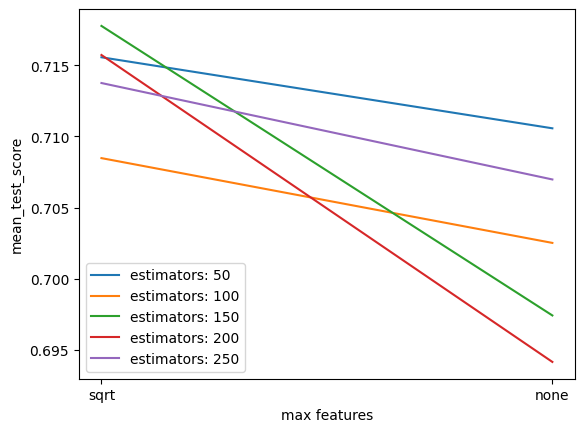

In [12]:
paired_results = pairResults(rf_results)

n50, n100, n150, n200, n250 = [],[],[],[], []

for record in paired_results:
    if record[1]["n_estimators"] == 50:
        n50.append(record[0])
    elif record[1]["n_estimators"] == 100:
        n100.append(record[0])
    elif record[1]["n_estimators"] == 150:
        n150.append(record[0])
    elif record[1]["n_estimators"] == 200:
        n200.append(record[0])
    else:
        n250.append(record[0])


plt.plot(n50, label="estimators: 50")
plt.plot(n100, label="estimators: 100")
plt.plot(n150, label="estimators: 150")
plt.plot(n200, label="estimators: 200")
plt.plot(n250, label="estimators: 250")


plt.xlabel("max features")
plt.xticks([0, 1], ["sqrt", "none"])
plt.ylabel("mean_test_score")
plt.legend()
plt.show()


In [13]:
### SVM ###

parameters = {
    "C": [0.01, 0.1, 1, 10],
    "kernel": ["linear", "rbf"], # sigmoid -> overfit
}


svm_results, best_params = findBestParameters(SVC(), parameters, X_train, y_train)
svm = SVC(**best_params)

best_models.append(svm)

Grid Best Params: {'C': 0.01, 'kernel': 'linear'}


(np.float64(0.726273964131107), {'C': 0.01, 'kernel': 'linear'})
(np.float64(0.5), {'C': 0.01, 'kernel': 'rbf'})
(np.float64(0.7176430117501547), {'C': 0.1, 'kernel': 'linear'})
(np.float64(0.7036448670377242), {'C': 0.1, 'kernel': 'rbf'})
(np.float64(0.7196938775510204), {'C': 1, 'kernel': 'linear'})
(np.float64(0.7133511131725416), {'C': 1, 'kernel': 'rbf'})
(np.float64(0.7196938775510204), {'C': 10, 'kernel': 'linear'})
(np.float64(0.6857382498453928), {'C': 10, 'kernel': 'rbf'})


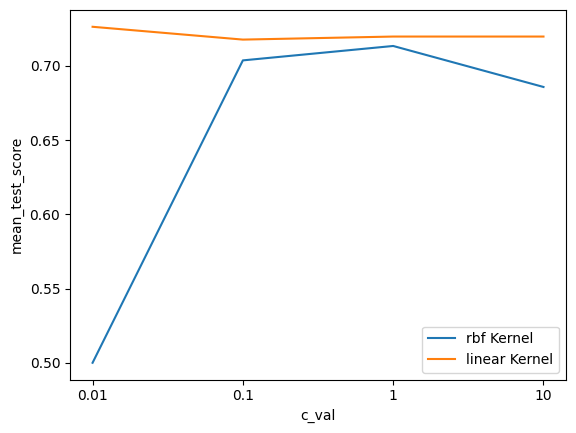

In [14]:
paired_results = pairResults(svm_results)
for record in paired_results:
    print(record)

rbf_kernel = []
linear_kernel = []

for record in paired_results:
    if record[1]["kernel"] == "rbf":
        rbf_kernel.append(record[0])
    else:
        linear_kernel.append(record[0])

plt.plot(rbf_kernel, label="rbf Kernel")
plt.plot(linear_kernel, label="linear Kernel")

plt.xlabel("c_val")
plt.xticks([0, 1, 2, 3], ["0.01", "0.1", "1", "10"])
plt.ylabel("mean_test_score")
plt.legend()
plt.show()

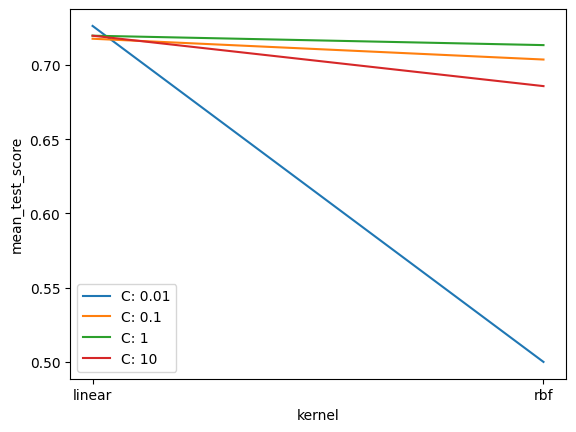

In [15]:
paired_results = pairResults(svm_results)

c001, c01,c1,c10 = [],[],[],[]

for record in paired_results:
    if record[1]["C"] == 0.01:
        c001.append(record[0])
    elif record[1]["C"] == 0.1:
        c01.append(record[0])
    elif record[1]["C"] == 1:
        c1.append(record[0])
    else:
        c10.append(record[0])


plt.plot(c001, label="C: 0.01")
plt.plot(c01, label="C: 0.1")
plt.plot(c1, label="C: 1")
plt.plot(c10, label="C: 10")

plt.xlabel("kernel")
plt.xticks([0, 1], ["linear", "rbf"])
plt.ylabel("mean_test_score")
plt.legend()
plt.show()


In [16]:
### Logistic Regression ###

parameters = {
    # C:0.01 -> overfit
    "C": [0.1, 1, 10, 100],
    #max_iter: 5, 10, 15 -> fails to converge on test data
    #          150, 200, 250, 300 -> no improvment
    "max_iter": [25, 50, 100, 150, 200, 250, 300],
}


lr_results, best_params = findBestParameters(LogisticRegression(),
                                             parameters, X_train, y_train)
lr = LogisticRegression(**best_params)

best_models.append(lr)

Grid Best Params: {'C': 0.1, 'max_iter': 25}


(np.float64(0.7368707482993196), {'C': 0.1, 'max_iter': 25})
(np.float64(0.7368707482993196), {'C': 0.1, 'max_iter': 50})
(np.float64(0.7368707482993196), {'C': 0.1, 'max_iter': 100})
(np.float64(0.7368707482993196), {'C': 0.1, 'max_iter': 150})
(np.float64(0.7368707482993196), {'C': 0.1, 'max_iter': 200})
(np.float64(0.7368707482993196), {'C': 0.1, 'max_iter': 250})
(np.float64(0.7368707482993196), {'C': 0.1, 'max_iter': 300})
(np.float64(0.734829931972789), {'C': 1, 'max_iter': 25})
(np.float64(0.734829931972789), {'C': 1, 'max_iter': 50})
(np.float64(0.734829931972789), {'C': 1, 'max_iter': 100})
(np.float64(0.734829931972789), {'C': 1, 'max_iter': 150})
(np.float64(0.734829931972789), {'C': 1, 'max_iter': 200})
(np.float64(0.734829931972789), {'C': 1, 'max_iter': 250})
(np.float64(0.734829931972789), {'C': 1, 'max_iter': 300})
(np.float64(0.734829931972789), {'C': 10, 'max_iter': 25})
(np.float64(0.734829931972789), {'C': 10, 'max_iter': 50})
(np.float64(0.734829931972789), {'C': 1

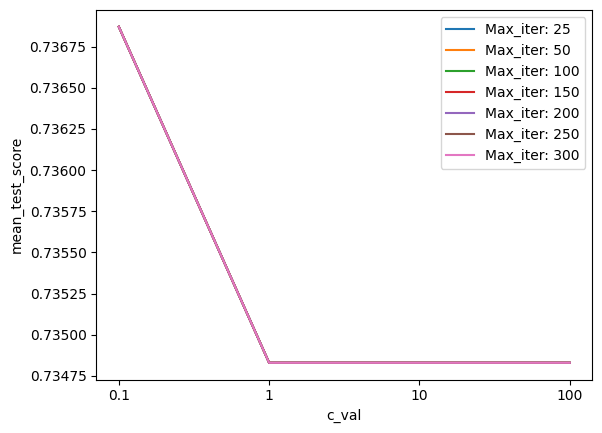

In [17]:
paired_results = pairResults(lr_results)
for record in paired_results:
    print(record)

i25, i50, i100, i150, i200, i250, i300 = [], [], [], [], [], [], []

for record in paired_results:
    if record[1]["max_iter"] == 25:
        i25.append(record[0])
    elif record[1]["max_iter"] == 50:
        i50.append(record[0])
    elif record[1]["max_iter"] == 100:
        i100.append(record[0])
    elif record[1]["max_iter"] == 150:
        i150.append(record[0])
    elif record[1]["max_iter"] == 200:
        i200.append(record[0])
    elif record[1]["max_iter"] == 250:
        i250.append(record[0])
    else:
        i300.append(record[0])

plt.plot(i25, label="Max_iter: 25")
plt.plot(i50, label="Max_iter: 50")
plt.plot(i100, label="Max_iter: 100")
plt.plot(i150, label="Max_iter: 150")
plt.plot(i200, label="Max_iter: 200")
plt.plot(i250, label="Max_iter: 250")
plt.plot(i300, label="Max_iter: 300")


plt.xlabel("c_val")
plt.xticks([0, 1, 2, 3], ["0.1", "1", "10", "100"])
plt.ylabel("mean_test_score")
plt.legend()
plt.show()

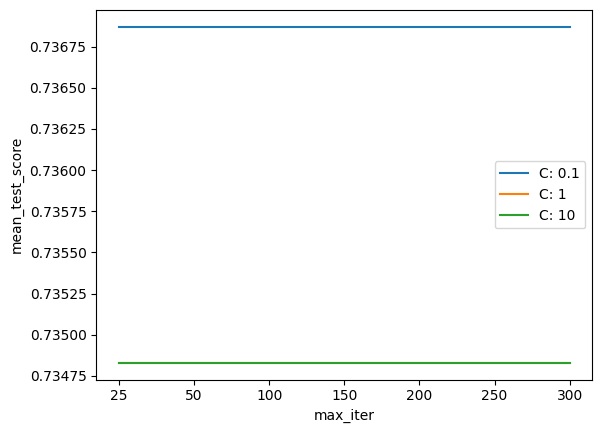

In [18]:
paired_results = pairResults(lr_results)

c01,c1,c10,c100 = [],[],[],[]
max_iter = []

for record in paired_results:
    if record[1]["C"] == 0.1:
        c01.append(record[0])
        max_iter.append(record[1]["max_iter"])
    elif record[1]["C"] == 1:
        c1.append(record[0])
    elif record[1]["C"] == 10:
        c10.append(record[0])
    else:
        c100.append(record[0])


plt.plot(c01, label="C: 0.1")
plt.plot(c1, label="C: 1")
plt.plot(c10, label="C: 10")

plt.xlabel("max_iter")
plt.xticks([0, 1, 2, 3, 4, 5, 6], ["25", "50", "100", "150", "200", "250", "300"])
plt.ylabel("mean_test_score")
plt.legend()
plt.show()


---

# 3. **Evaluate models**

Here, you need to:

1.	test the model (the best one you obtained from the above stage) on the testing dataset.


In [ ]:
# Write your proposed solution code here.
# Create more code cells if you find it necessary

for model in best_models:
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)
    print("model:", model)
    print("Best classification report:","\n",
          classification_report(y_test, y_predict))
    print("Best balanced accuracy =",
          balanced_accuracy_score(y_test, y_predict))
    con_matrix = confusion_matrix(y_test, y_predict)
    print("Best Confusion matrix:", "\n", con_matrix, "\n","\n")
